In [1]:
library(Signac)
library(Seurat)
library(GenomicRanges)
library(future)

plan("multicore", workers = 4)
options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.4.1 but the current version is
4.4.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, s

In [2]:
library(GenomicRanges)

In [5]:
# read in peak sets
peaks.w10_5eyes<- read.table(
  file = "atac_105w/eyes_atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.w10_5nose <- read.table(
  file = "atac_105w/nose_atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.w10_5jaw <- read.table(
  file = "atac_105w/jaw_atac_peaks.bed",
  col.names = c("chr", "start", "end"))

    
peaks.w6eyes <- read.table(
  file = "atac_6w/eyes_atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.w6nose <- read.table(
  file = "atac_6w/nose_atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.w6jaw <- read.table(
  file = "atac_6w/jaw_atac_peaks.bed",
  col.names = c("chr", "start", "end"))

    
peaks.w11eyes <- read.table(
  file = "MO_24_020/outs/atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.w11nose <- read.table(
  file = "MO_24_021/outs/atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.w11jaw <- read.table(
  file = "MO_24_019/outs/atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.w11rest<- read.table(
  file = "MO_24_022/outs/atac_peaks.bed",
  col.names = c("chr", "start", "end"))




In [6]:
peaks.Px_101 <- read.table(
  file = "Px_101/atac_peaks.bed",
  col.names = c("chr", "start", "end"))
peaks.Px_102<- read.table(
  file = "Px_102/atac_peaks.bed",
  col.names = c("chr", "start", "end"))

In [7]:
# convert to genomic ranges
gr.w10_5eyes <- makeGRangesFromDataFrame(peaks.w10_5eyes)
gr.w10_5nose <- makeGRangesFromDataFrame(peaks.w10_5nose)
gr.w10_5jaw <- makeGRangesFromDataFrame(peaks.w10_5jaw)

gr.w6eyes <- makeGRangesFromDataFrame(peaks.w6eyes)
gr.w6nose <- makeGRangesFromDataFrame(peaks.w6nose)
gr.w6jaw <- makeGRangesFromDataFrame(peaks.w6jaw)

gr.w11eyes <- makeGRangesFromDataFrame(peaks.w11eyes)
gr.w11nose <- makeGRangesFromDataFrame(peaks.w11nose)
gr.w11jaw <- makeGRangesFromDataFrame(peaks.w11jaw)
gr.w11rest <- makeGRangesFromDataFrame(peaks.w11rest)



In [9]:
gr.Px_101 <- makeGRangesFromDataFrame(peaks.Px_101)
gr.Px_102 <- makeGRangesFromDataFrame(peaks.Px_102)

In [17]:
# Create a unified set of peaks to quantify in each dataset
combined.peaks <- reduce(x = c(gr.w10_5eyes, gr.w10_5nose, gr.w10_5jaw, gr.w6eyes, gr.w6nose, gr.w6jaw, 
                               gr.w11eyes, gr.w11nose, gr.w11jaw, gr.w11rest, gr.Px_101,gr.Px_102))
# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)

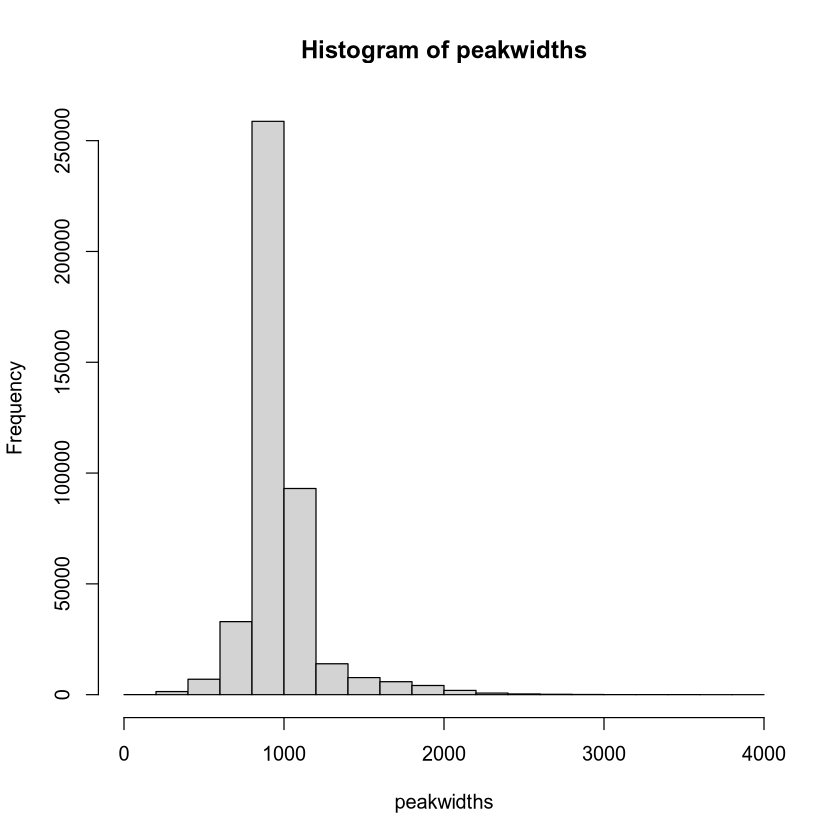

In [18]:
hist(peakwidths)

In [13]:
plan("multicore", workers = 20)

In [19]:
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 100]
combined.peaks

GRanges object with 427997 ranges and 0 metadata columns:
             seqnames        ranges strand
                <Rle>     <IRanges>  <Rle>
       [1]       chr1    9779-10697      *
       [2]       chr1 180568-181865      *
       [3]       chr1 183921-184894      *
       [4]       chr1 191036-191957      *
       [5]       chr1 267560-268548      *
       ...        ...           ...    ...
  [427993] KI270731.1     4504-5403      *
  [427994] KI270734.1 130429-131382      *
  [427995] KI270734.1 131898-132784      *
  [427996] KI270734.1 133478-134447      *
  [427997] KI270734.1 142657-143561      *
  -------
  seqinfo: 34 sequences from an unspecified genome; no seqlengths

In [26]:
##download barcodes and add to fragments
# Provide a list of high-quality cell barcodes (vector) - took from scRNA matrixes

# Create the fragment object with the cell barcodes subset
frags.w10_5eyes <- CreateFragmentObject(
  path = "atac_105w/atac_fragments_eyes.tsv.gz",
  cells = readLines("/home/rgalimullina/face_project/joint_dataset/atac_105w/barcodes_eyes.tsv.gz")
)

frags.w10_5nose <- CreateFragmentObject(
  path = "atac_105w/atac_fragments_nose.tsv.gz",
  cells = readLines("atac_105w/barcodes_nose.tsv.gz")
)

frags.w10_5jaw <- CreateFragmentObject(
  path = "atac_105w/atac_fragments_jaw.tsv.gz",
  cells = readLines("atac_105w/barcodes_jaw.tsv.gz")
)



frags.w6eyes<- CreateFragmentObject(
  path = "week6/eye_atac_fragments.tsv.gz",
  cells = readLines("week6/barcodes_eyes.tsv.gz")
)

frags.w6nose<- CreateFragmentObject(
  path = "week6/data/nose_atac_fragments.tsv.gz",
  cells = readLines("week6/barcodes_nose.tsv.gz")
)

frags.w6jaw<- CreateFragmentObject(
  path = "week6/jaw_atac_fragments.tsv.gz",
  cells = readLines("week6/barcodes_jaw.tsv.gz")
)


#newest 11w
frags.w11eyes<- CreateFragmentObject(
  path = "MO_24_020/outs/atac_fragments.tsv.gz",
  cells = readLines("/home/rgalimullina/face_project/new_11w/new_11w_face/barcodes_eyes.tsv.gz")
)
frags.w11nose<- CreateFragmentObject(
  path = "MO_24_021/outs/atac_fragments.tsv.gz",
  cells = readLines("new_11w_face/barcodes_nose.tsv.gz")
)
frags.w11jaw<- CreateFragmentObject(
  path = "MO_24_019/outs/atac_fragments.tsv.gz",
  cells = readLines("new_11w_face/barcodes_jaw.tsv.gz")
)
frags.w11rest<- CreateFragmentObject(
  path = "MO_24_022/outs/atac_fragments.tsv.gz",
  cells = readLines("new_11w_face/barcodes_rest.tsv.gz")
)



Computing hash

Computing hash

Computing hash

Computing hash

Computing hash

Computing hash

Computing hash

Computing hash

Computing hash

Computing hash



In [27]:
frags.Px_101<- CreateFragmentObject(
  path = "Px_101/outs/atac_fragments.tsv.gz",
  cells = readLines("Px_101/outs/filtered_feature_bc_matrix/barcodes.tsv.gz")
)
frags.Px_102<- CreateFragmentObject(
  path = "Px_102/outs/atac_fragments.tsv.gz",
  cells = readLines("Px_102/outs/filtered_feature_bc_matrix/barcodes.tsv.gz")
)

Computing hash

Computing hash



In [28]:
#Quantify peaks in each dataset

w10_5eyes.counts <- FeatureMatrix(
  fragments = frags.w10_5eyes,
  features = combined.peaks,
  cells = readLines("atac_105w/barcodes_eyes.tsv.gz")
)

w10_5nose.counts <- FeatureMatrix(
  fragments = frags.w10_5nose,
  features = combined.peaks,
  cells = readLines("atac_105w/barcodes_nose.tsv.gz")
)
w10_5jaw.counts <- FeatureMatrix(
  fragments = frags.w10_5jaw,
  features = combined.peaks,
  cells = readLines("atac_105w/barcodes_jaw.tsv.gz")
)





Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [29]:
w6eyes.counts <- FeatureMatrix(
  fragments = frags.w6eyes,
  features = combined.peaks,
  cells = readLines("week6/barcodes_eyes.tsv.gz")
)
w6nose.counts <- FeatureMatrix(
  fragments = frags.w6nose,
  features = combined.peaks,
  cells = readLines("week6/barcodes_nose.tsv.gz")
)
w6jaw.counts <- FeatureMatrix(
  fragments = frags.w6jaw,
  features = combined.peaks,
  cells = readLines("week6/barcodes_jaw.tsv.gz")
)


Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [30]:
library(BSgenome.Hsapiens.UCSC.hg38)
library(EnsDb.Hsapiens.v86)
set.seed(1234)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO

Loading required package: rtracklayer


Attaching package: ‘rtracklayer’


The following object is masked from ‘package:BiocIO’:

    FileForFormat


Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: AnnotationFilter


Attaching package: ‘AnnotationFilter’


The following object is masked from ‘package:future’:

    value



Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filt

In [31]:
# get gene annotations for hg38
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotation) <- "UCSC"
genome(annotation) = "hg38"

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [33]:
## create  Objects
w10_5eyes_assay <- CreateChromatinAssay(w10_5eyes.counts, fragments = frags.w10_5eyes)
w10_5eyes <- CreateSeuratObject(w10_5eyes_assay, assay = "ATAC", annotation = annotation)

w10_5nose_assay <- CreateChromatinAssay(w10_5nose.counts, fragments = frags.w10_5nose)
w10_5nose <- CreateSeuratObject(w10_5nose_assay, assay = "ATAC", annotation = annotation)

w10_5jaw_assay <- CreateChromatinAssay(w10_5jaw.counts, fragments = frags.w10_5jaw)
w10_5jaw <- CreateSeuratObject(w10_5jaw_assay, assay = "ATAC", annotation = annotation)


w6eyes_assay <- CreateChromatinAssay(w6eyes.counts, fragments = frags.w6eyes)
w6eyes <- CreateSeuratObject(w6eyes_assay, assay = "ATAC", annotation = annotation)

w6nose_assay <- CreateChromatinAssay(w6nose.counts, fragments = frags.w6nose)
w6nose <- CreateSeuratObject(w6nose_assay, assay = "ATAC", annotation = annotation)

w6jaw_assay <- CreateChromatinAssay(w6jaw.counts, fragments = frags.w6jaw)
w6jaw <- CreateSeuratObject(w6jaw_assay, assay = "ATAC", annotation = annotation)

In [34]:
##remove unnessesary objects
rm(w10_5eyes.counts, w10_5nose.counts, w10_5jaw.counts, w6eyes.counts, w6nose.counts, w6jaw.counts, frags.w6nose, frags.w6jaw, frags.w6eyes, frags.w10_5jaw,
   frags.w10_5nose, frags.w10_5eyes)

In [35]:
saveRDS(w10_5eyes, 'w10_5eyes.rds')
saveRDS(w10_5nose, 'w10_5nose.rds')
saveRDS(w10_5jaw, "w10_5jaw.rds")


saveRDS(w6eyes, "w6eyes.rds")
saveRDS(w6nose, "w6nose.rds")
saveRDS(w6jaw, "w6jaw.rds")

In [36]:
rm(w6jaw_assay, w6nose_assay, w6eyes_assay, w10_5eyes_assay, w10_5jaw_assay, w10_5nose_assay)

In [38]:
w11eyes.counts <- FeatureMatrix(
  fragments = frags.w11eyes,
  features = combined.peaks,
  cells = readLines("new_11w_face/barcodes_eyes.tsv.gz")
)
w11eyes_assay <- CreateChromatinAssay(w11eyes.counts, fragments = frags.w11eyes)
w11eyes <- CreateSeuratObject(w11eyes_assay, assay = "ATAC", annotation = annotation)
saveRDS(w11eyes, 'w11eyes.rds')
rm(w11eyes.counts, frags.w11eyes)


w11nose.counts <- FeatureMatrix(
  fragments = frags.w11nose,
  features = combined.peaks,
  cells = readLines("new_11w_face/barcodes_nose.tsv.gz")
)
w11nose_assay <- CreateChromatinAssay(w11nose.counts, fragments = frags.w11nose)
w11nose <- CreateSeuratObject(w11nose_assay, assay = "ATAC", annotation = annotation)
saveRDS(w11nose, 'w11nose.rds')
rm(w11nose.counts, frags.w11nose)

w11jaw.counts <- FeatureMatrix(
  fragments = frags.w11jaw,
  features = combined.peaks,
  cells = readLines("new_11w_face/barcodes_jaw.tsv.gz")
)
w11jaw_assay <- CreateChromatinAssay(w11jaw.counts, fragments = frags.w11jaw)
w11jaw <- CreateSeuratObject(w11jaw_assay, assay = "ATAC", annotation = annotation)
saveRDS(w11jaw, 'w11jaw.rds')
rm(w11jaw.counts, frags.w11jaw)


w11rest.counts <- FeatureMatrix(
  fragments = frags.w11rest,
  features = combined.peaks,
  cells = readLines("new_11w_face/barcodes_rest.tsv.gz")
)
w11rest_assay <- CreateChromatinAssay(w11rest.counts, fragments = frags.w11rest)
w11rest <- CreateSeuratObject(w11rest_assay, assay = "ATAC", annotation = annotation)
saveRDS(w11rest, 'w11rest.rds')
rm(w11rest.counts, frags.w11rest)





Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [39]:
rm(w11eyes_assay, w11nose_assay, w11jaw_assay, w11rest_assay)


In [40]:
Px_101.counts <- FeatureMatrix(
  fragments = frags.Px_101,
  features = combined.peaks,
  cells = readLines("Px_101/outs/filtered_feature_bc_matrix/barcodes.tsv.gz")
)
Px_101_assay <- CreateChromatinAssay(Px_101.counts, fragments = frags.Px_101)
Px_101 <- CreateSeuratObject(Px_101_assay, assay = "ATAC", annotation = annotation)
saveRDS(Px_101, 'Px_101.rds')
rm(Px_101.counts, frags.Px_101)



Px_102.counts <- FeatureMatrix(
  fragments = frags.Px_102,
  features = combined.peaks,
  cells = readLines("Px_102/outs/filtered_feature_bc_matrix/barcodes.tsv.gz")
)
Px_102_assay <- CreateChromatinAssay(Px_102.counts, fragments = frags.Px_102)
Px_102 <- CreateSeuratObject(Px_102_assay, assay = "ATAC", annotation = annotation)
saveRDS(Px_102, 'Px_102.rds')
rm(Px_102.counts, frags.Px_102)

Warning message in SingleFeatureMatrix(fragment = fragments[[x]], features = features, :
"18 features are on seqnames not present in the fragment file. These will be removed."
Extracting reads overlapping genomic regions

Warning message in SingleFeatureMatrix(fragment = fragments[[x]], features = features, :
"18 features are on seqnames not present in the fragment file. These will be removed."
Extracting reads overlapping genomic regions



In [42]:


# add information to identify dataset of origin
w10_5nose$dataset <- 'w10_5nose'
w10_5jaw$dataset <- 'w10_5jaw'
w10_5eyes$dataset <- 'w10_5eyes'

w6eyes$dataset <- 'w6eyes'
w6jaw$dataset <- 'w6jaw'
w6nose$dataset <- 'w6nose'

w11eyes$dataset <- 'w11eyes'
w11jaw$dataset <- 'w11jaw'
w11nose$dataset <- 'w11nose'
w11rest$dataset <- 'w11rest'

Px_101$dataset <- 'w6_5_anterior'
Px_102$dataset <- 'w6_5_posterior'

# merge all datasets, adding a cell ID to make sure cell names are unique
combined <- merge(
  x = w10_5nose,
  y = list(w10_5jaw, w10_5eyes, w6eyes, w6jaw, w6nose, w11eyes, w11jaw, w11nose, w11rest, Px_101,Px_102 )
)
combined[["ATAC"]]


Warning message:
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


ChromatinAssay data with 427997 features for 126012 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 12 

In [44]:
rm(w10_5nose,w10_5jaw, w10_5eyes, w6eyes, w6jaw, w6nose, w11eyes, w11jaw, w11nose, w11rest, Px_101,Px_102 )

In [43]:
saveRDS(combined, "combined_all_atac.rds")

In [46]:
combined <- RunTFIDF(combined)
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = 2:50, reduction = 'lsi')

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
15:55:41 UMAP embedding parameters a = 0.9922 b = 1.112

15:55:41 Read 126012 rows and found 49 numeric columns

15:55:41 Using Annoy for neighbor search, n_neighbors = 30

15:55:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:56:03 Writing NN index file to temp file /tmp/Rtmp1b6VUY/file2433cf121e4570

15:56:03 Searching Annoy index using 20 threads, search_k = 3000

15:56:06 Annoy recall = 100%

15:56:11 Commenc

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



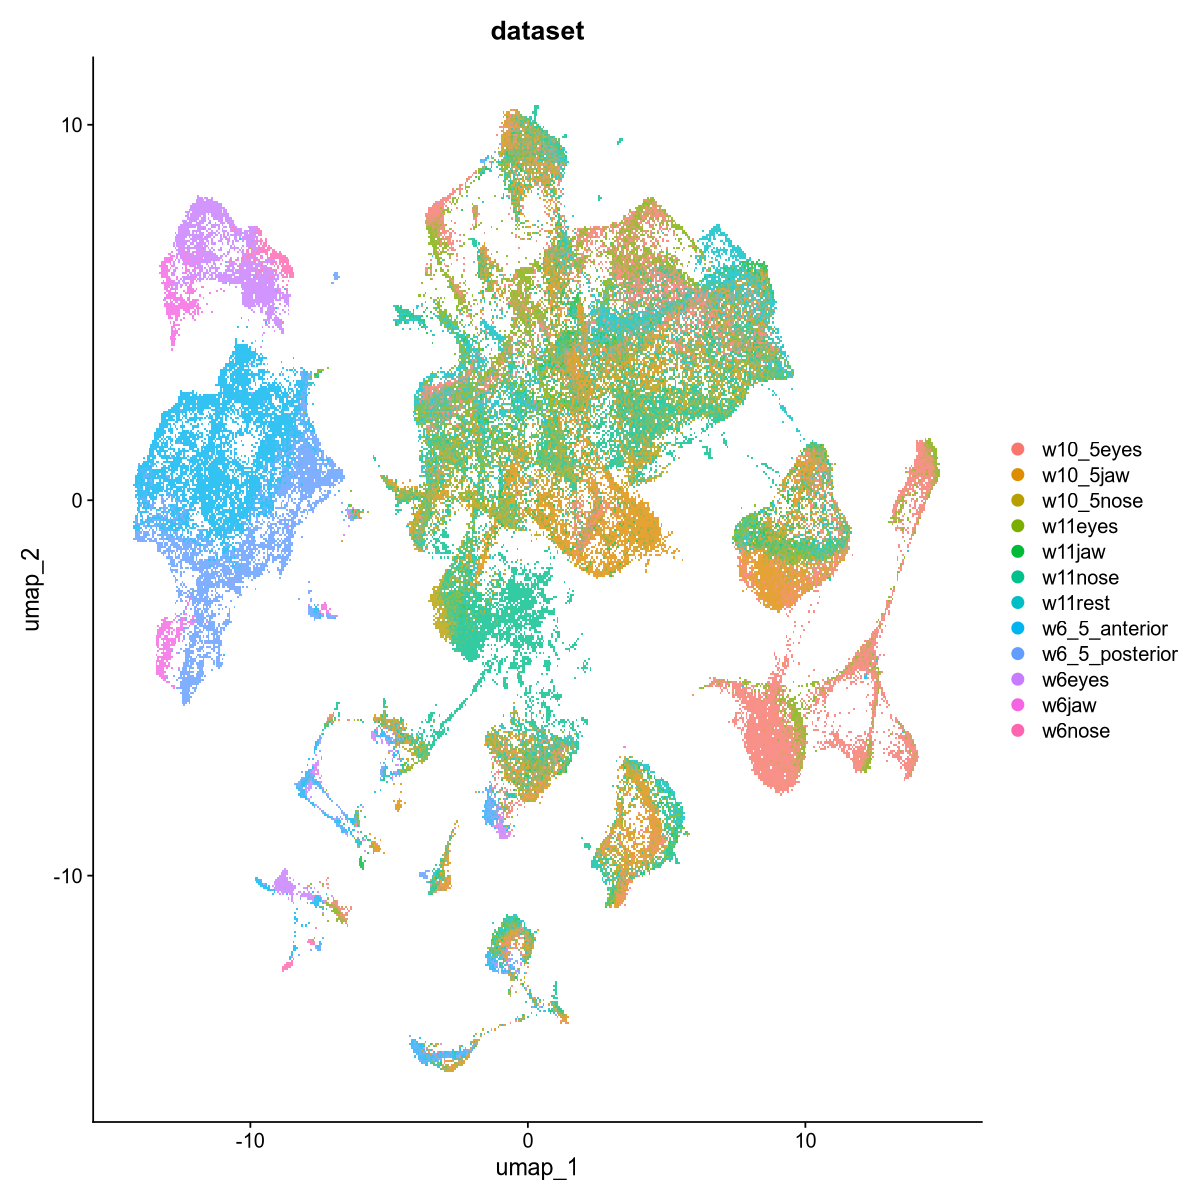

In [47]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(combined, group.by = 'dataset', pt.size = 0.8)

In [ ]:
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- "UCSC"  # Match the chromosome naming style (e.g., "chr1")
genome(annotations) <- "hg38"  # Specify genome version


Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [51]:
# Add gene annotations to the ATAC assay
Annotation(combined) <- annotations

In [ ]:
##some QC
# Calculate FRiP scores
combined <- NucleosomeSignal(combined)
combined <- TSSEnrichment(combined, fast = FALSE)



Extracting TSS positions

Finding + strand cut sites



In [51]:
library(ggplot2)

In [50]:
combined

An object of class Seurat 
427997 features across 126012 samples within 1 assay 
Active assay: ATAC (427997 features, 427991 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [59]:

# Filter out low-quality cells based on TSS enrichment
combined <- subset(combined, subset = TSS.enrichment < 10)

In [56]:
combined <- subset(combined, subset = TSS.enrichment > 4)

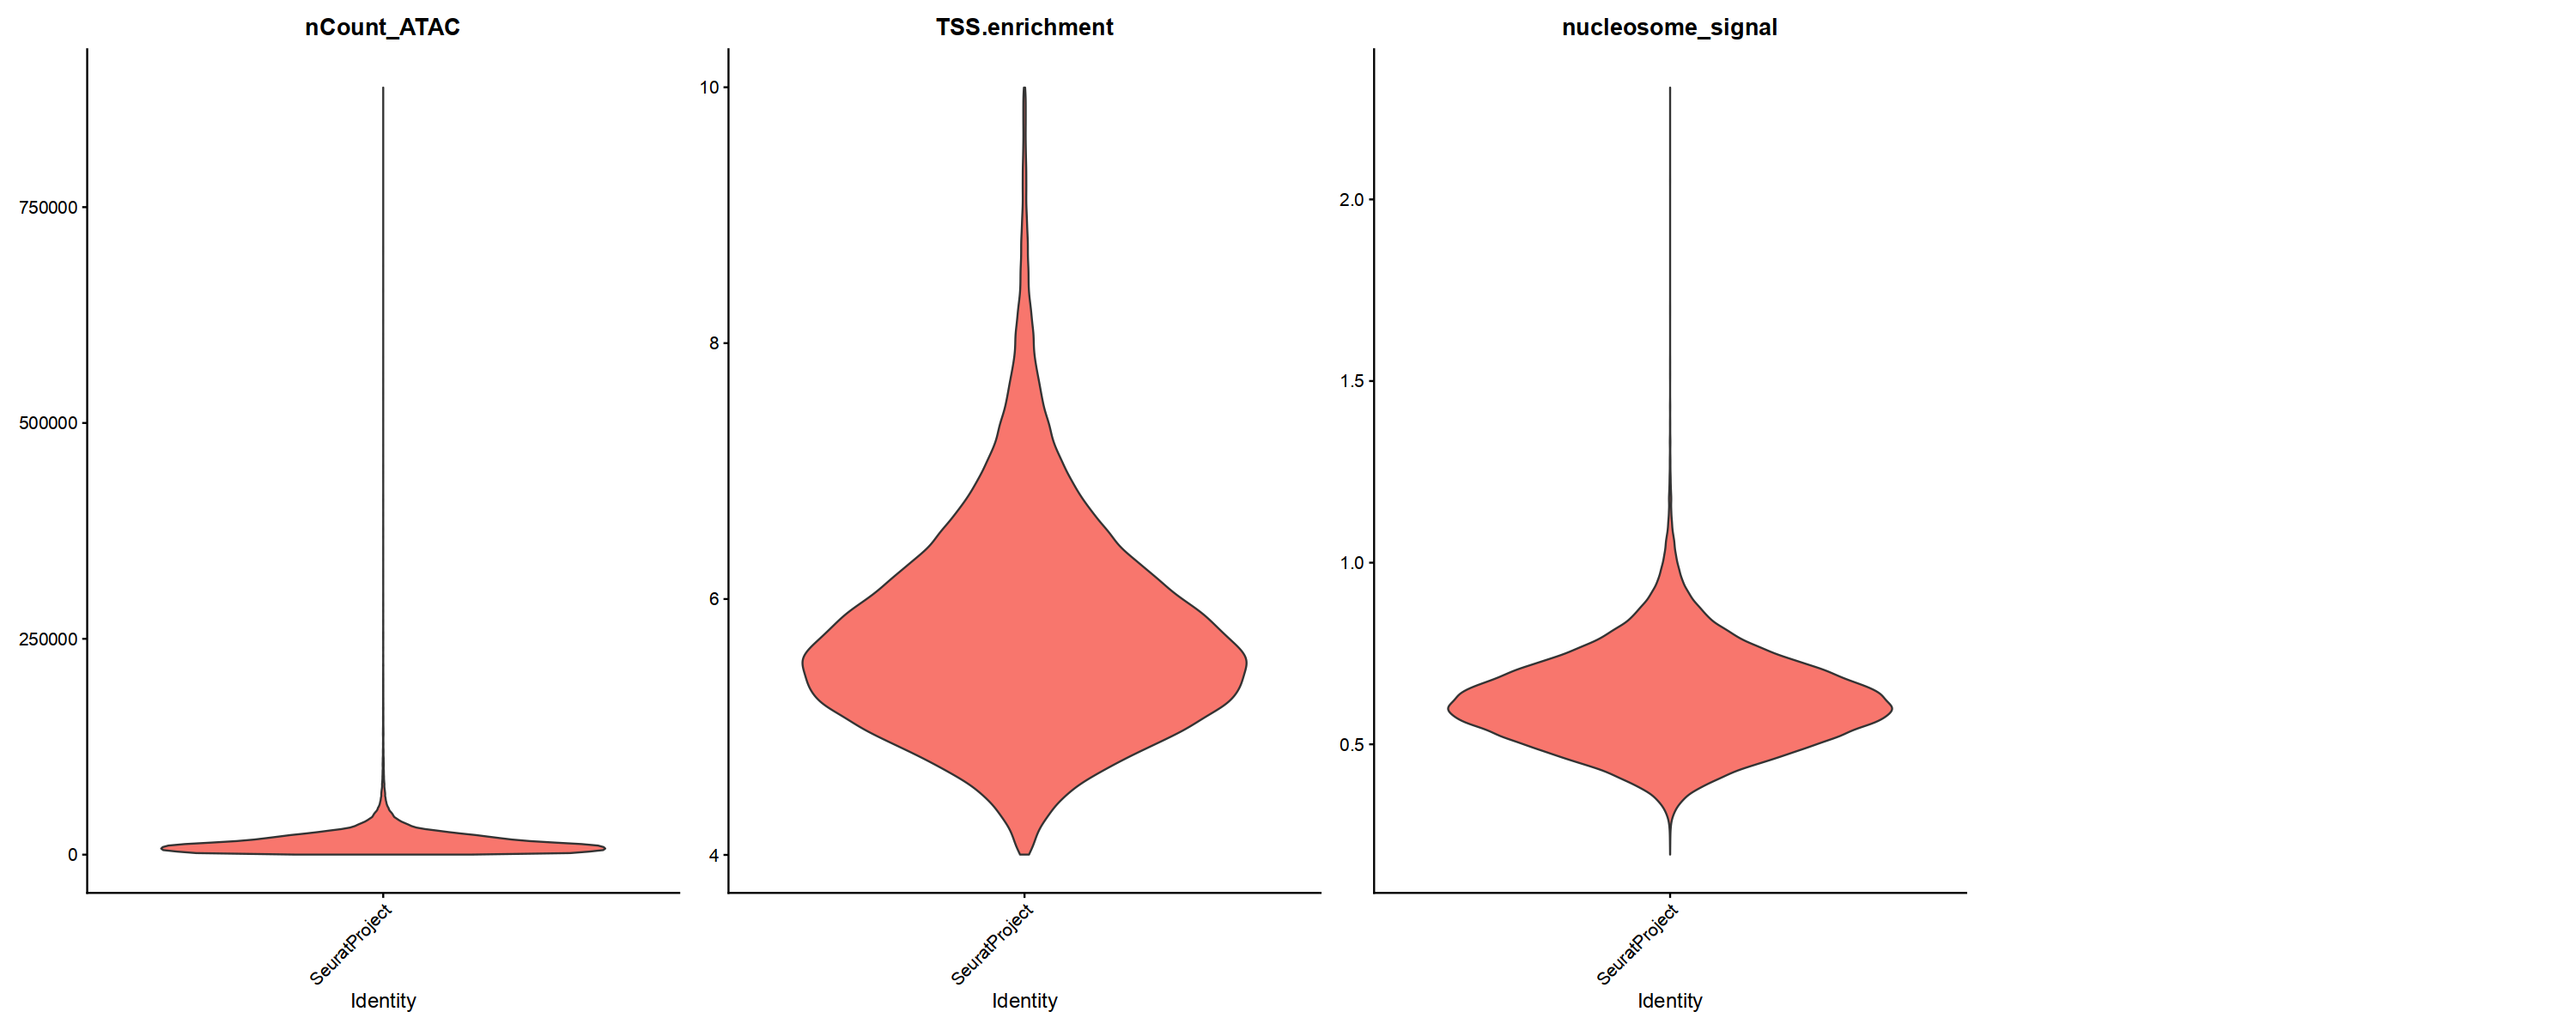

In [62]:
options(repr.plot.width=25, repr.plot.height=10)

VlnPlot(
  object = combined,
  features = c("nCount_ATAC", "TSS.enrichment", "nucleosome_signal"),
  ncol = 4,
  pt.size = 0
)

In [83]:
saveRDS(combined, "combined_all_atac.rds")

In [64]:
combined <- subset(combined, subset = nucleosome_signal < 1.5 &
                  nCount_ATAC < 250000)

Warning message:
"Removed 2087 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 20 rows containing missing values (`geom_bar()`)."


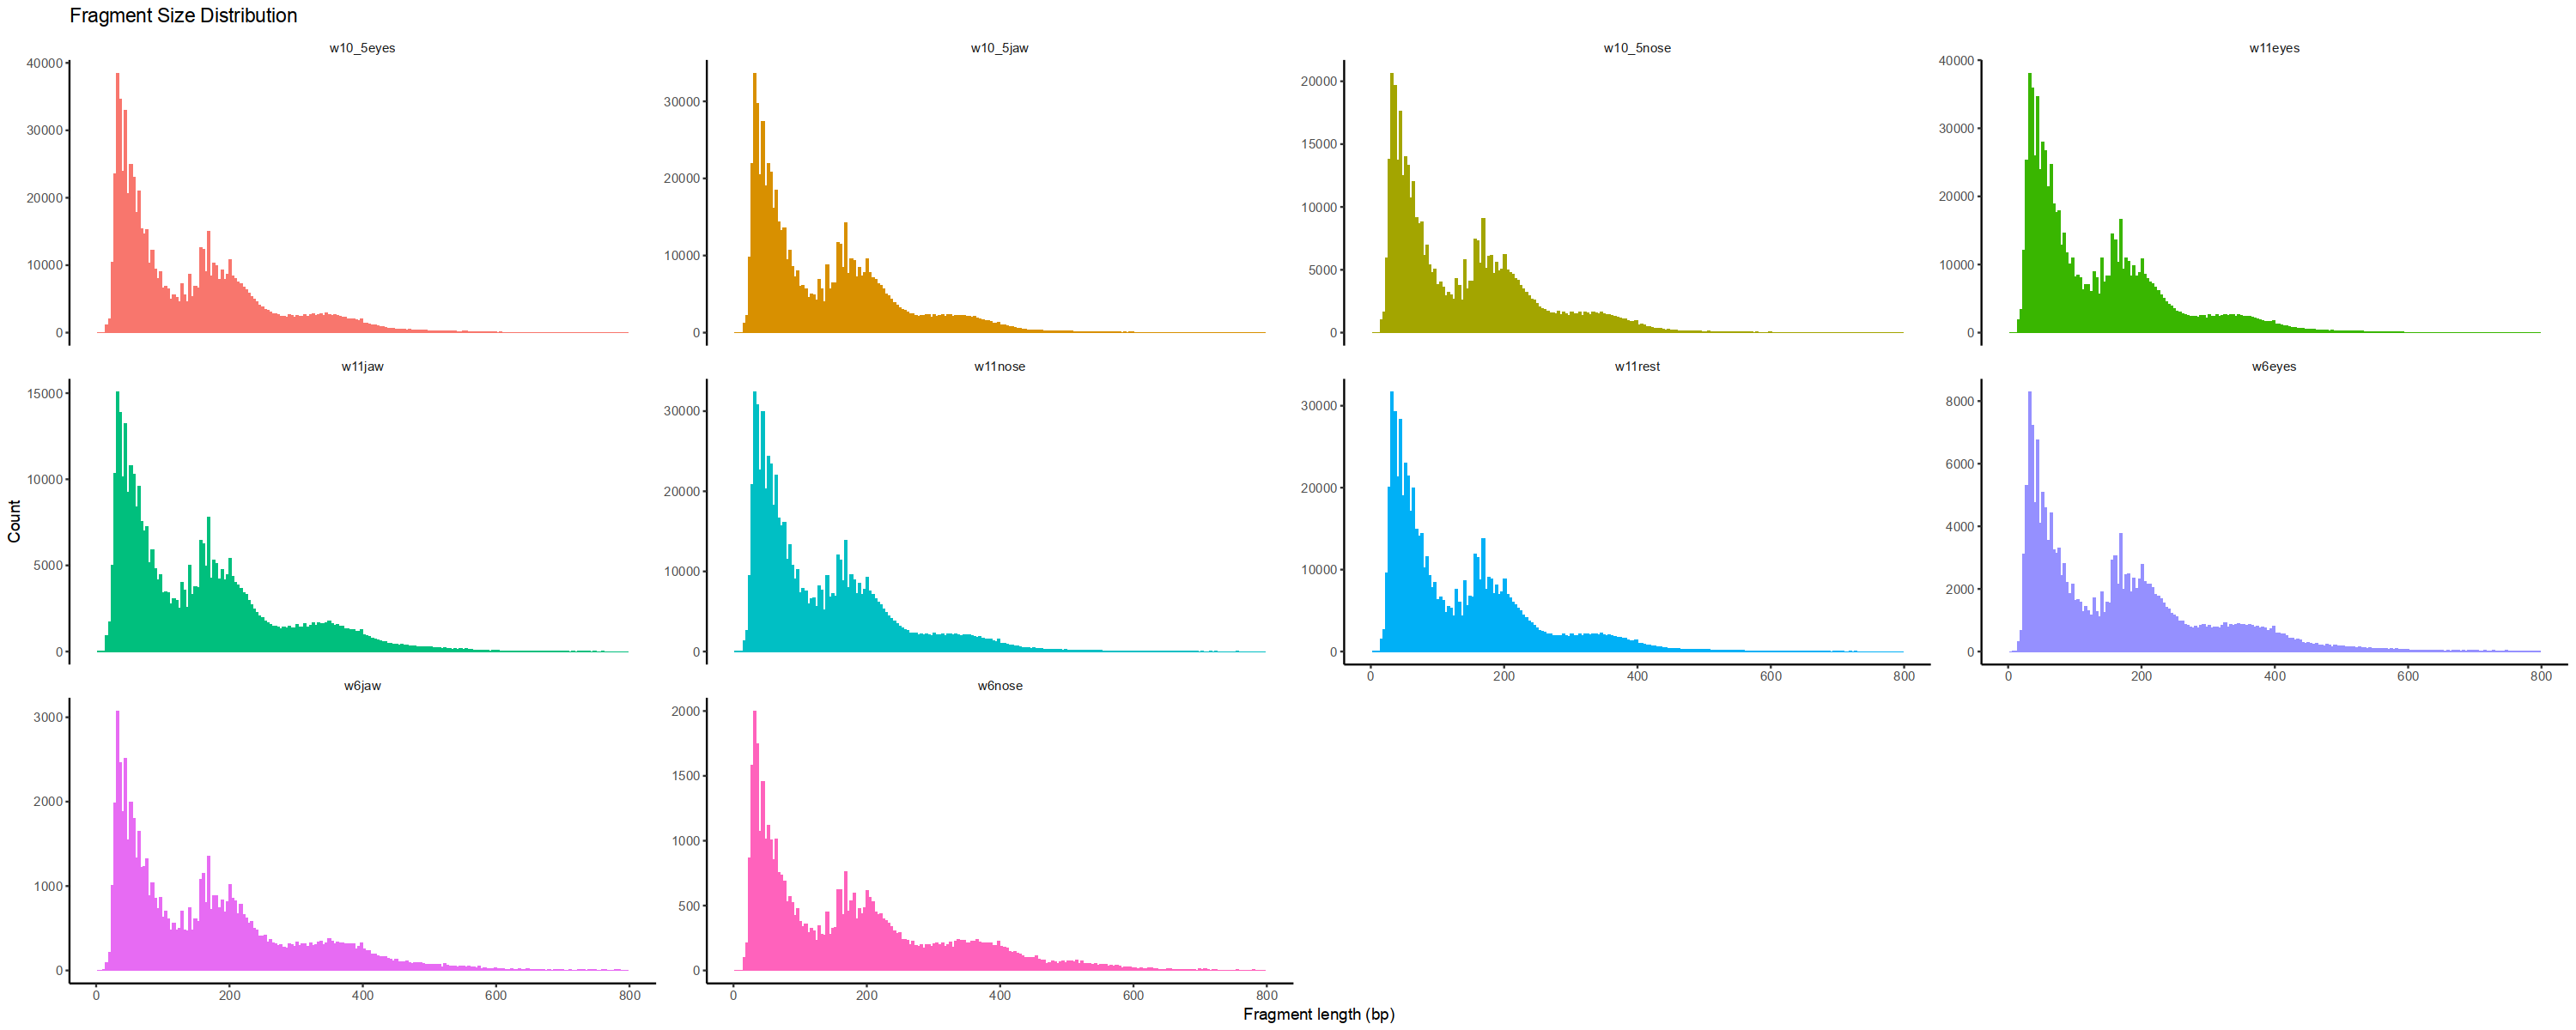

In [65]:
# Plot fragment size distribution to ensure the characteristic nucleosomal pattern
FragmentHistogram(object = combined, group.by = "dataset") + ggtitle("Fragment Size Distribution")

In [81]:
# add blacklist ratio
combined$blacklist_ratio <- FractionCountsInRegion(
  object = combined, 
  assay = 'ATAC',
  regions = blacklist_hg38_unified
)

In [3]:
library(SeuratDisk)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



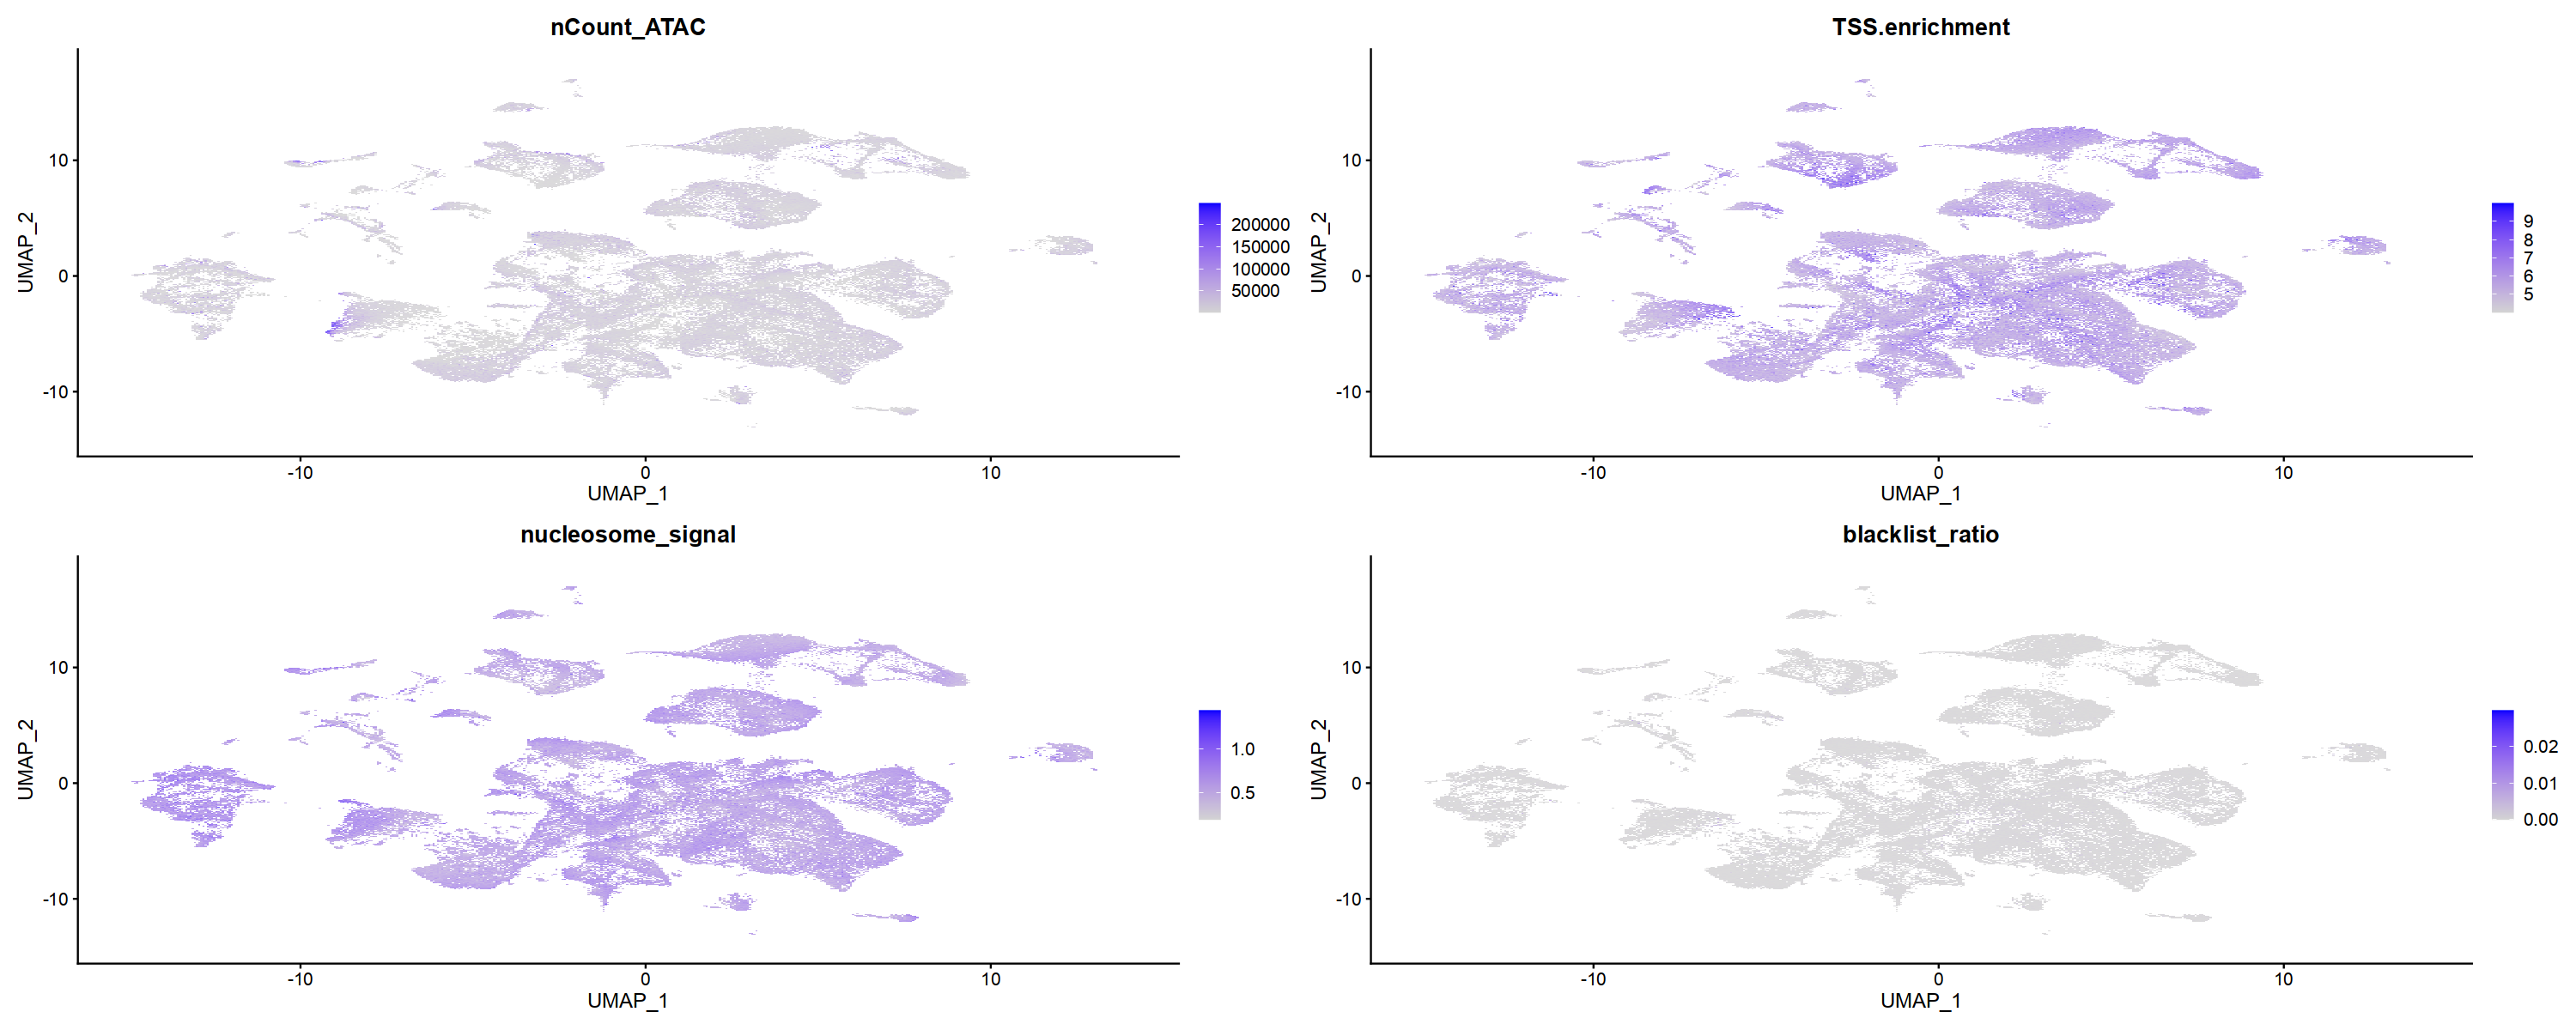

In [82]:
FeaturePlot(combined, features = c("nCount_ATAC", "TSS.enrichment", "nucleosome_signal", "blacklist_ratio"), pt.size = 0.8, ncol = 2)